Vibration meter data

Data loaded successfully!
Total samples: 200
Defective Rate: 20.0%



<ipython-input-4-6ede3b036ea1>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ng_data, x='Serial_Number_Short', y='Acceleration_m_s2', palette='Reds_r')
<ipython-input-4-6ede3b036ea1>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Status', y='Acceleration_m_s2',


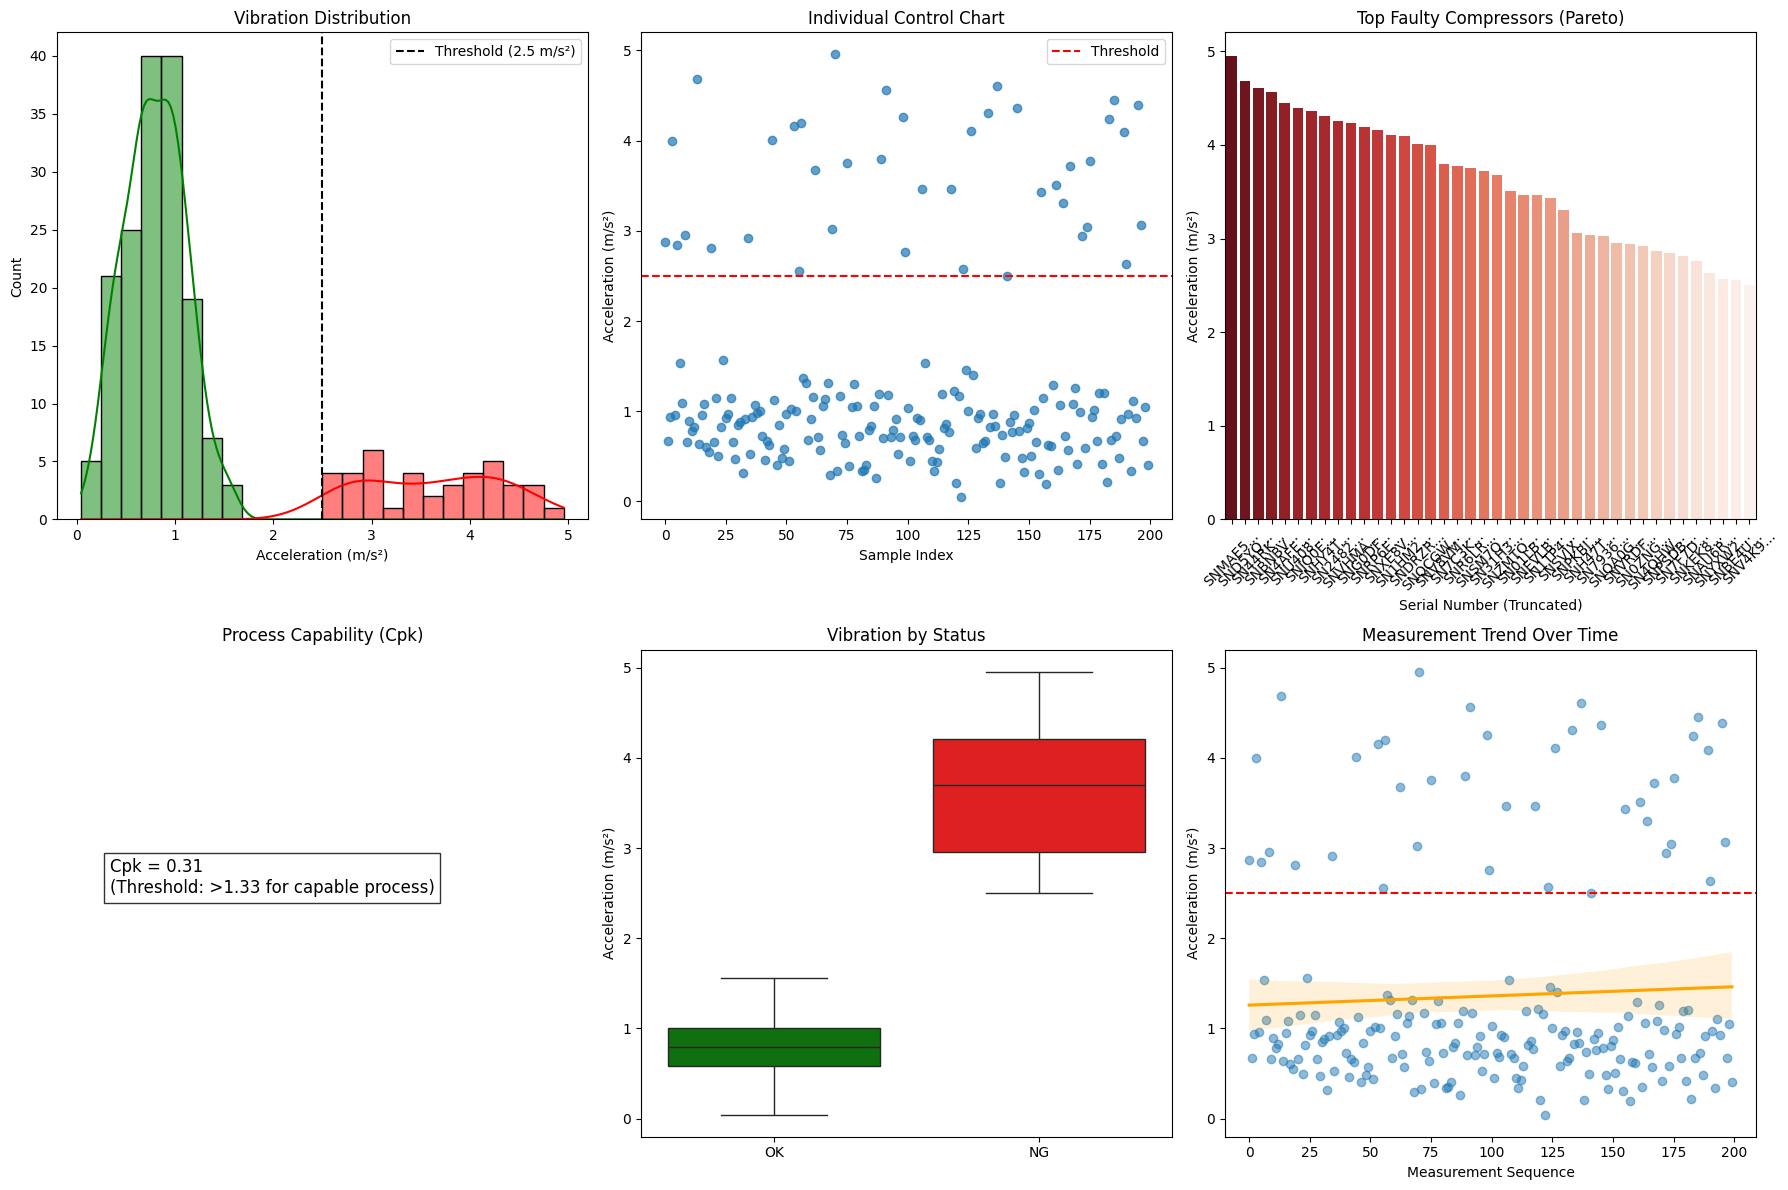


=== Statistical Validation ===
Mean (OK units): 0.80 m/s²
Mean (NG units): 3.62 m/s²
Std Dev: 1.21 m/s²

T-test Results:
T-statistic = -25.03
p-value = 3.081e-27
Significant difference (p < 0.05)

=== Data Quality Checks ===
Missing Values: 0
Unique Serial Numbers: True


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# =============================================
# 1. Load Data from CSV
# =============================================
try:
    data = pd.read_csv('/content/compressor_vibration_data_ok_ng.csv')

    # Validate required columns exist
    required_columns = ['Serial_Number', 'Acceleration_m_s2', 'Status']
    if not all(col in data.columns for col in required_columns):
        raise ValueError("CSV missing required columns. Needs: Serial_Number, Acceleration_m_s2, Status")

    print("Data loaded successfully!")
    print(f"Total samples: {len(data)}")
    print(f"Defective Rate: {100 * len(data[data['Status'] == 'NG']) / len(data):.1f}%\n")

except FileNotFoundError:
    print("Error: File not found at /content/compressor_vibration_data_ok_ng.csv")
    print("Please upload your CSV file to Colab first.")
    raise
except Exception as e:
    print(f"Error loading CSV: {str(e)}")
    raise

# =============================================
# 2. Enhanced Validation Charts
# =============================================
plt.figure(figsize=(18, 12))

# Chart 1: Distribution with Threshold
plt.subplot(2, 3, 1)
sns.histplot(data=data, x='Acceleration_m_s2', hue='Status',
             kde=True, palette={'OK':'green', 'NG':'red'})
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold (2.5 m/s²)')
plt.title('Vibration Distribution')
plt.xlabel('Acceleration (m/s²)')
plt.legend()

# Chart 2: Control Chart (Individual Measurements)
plt.subplot(2, 3, 2)
plt.plot(data['Acceleration_m_s2'], marker='o', linestyle='', alpha=0.7)
plt.axhline(y=2.5, color='red', linestyle='--', label='Threshold')
plt.title('Individual Control Chart')
plt.ylabel('Acceleration (m/s²)')
plt.xlabel('Sample Index')
plt.legend()

# Chart 3: Pareto Chart (Top Faulty Compressors)
plt.subplot(2, 3, 3)
ng_data = data[data['Status'] == 'NG'].sort_values('Acceleration_m_s2', ascending=False)
ng_data['Serial_Number_Short'] = ng_data['Serial_Number'].str[:6] + '...'  # Truncate for readability
if not ng_data.empty:
    sns.barplot(data=ng_data, x='Serial_Number_Short', y='Acceleration_m_s2', palette='Reds_r')
    plt.title('Top Faulty Compressors (Pareto)')
    plt.xlabel('Serial Number (Truncated)')
    plt.ylabel('Acceleration (m/s²)')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No NG Units Found', ha='center', va='center')
    plt.title('No Faulty Units')

# Chart 4: Process Capability Analysis
plt.subplot(2, 3, 4)
cpk_value = (2.5 - data['Acceleration_m_s2'].mean()) / (3 * data['Acceleration_m_s2'].std())
plt.text(0.1, 0.5, f'Cpk = {cpk_value:.2f}\n(Threshold: >1.33 for capable process)',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.axis('off')
plt.title('Process Capability (Cpk)')

# Chart 5: Boxplot by Status
plt.subplot(2, 3, 5)
sns.boxplot(data=data, x='Status', y='Acceleration_m_s2',
            palette={'OK':'green', 'NG':'red'}, order=['OK', 'NG'])
plt.title('Vibration by Status')
plt.ylabel('Acceleration (m/s²)')
plt.xlabel('')

# Chart 6: Time-series Trend (Using Index as Proxy)
plt.subplot(2, 3, 6)
data['Measurement_Order'] = np.arange(len(data))  # Use index as measurement sequence
sns.regplot(data=data, x='Measurement_Order', y='Acceleration_m_s2',
            scatter_kws={'alpha':0.5}, line_kws={'color':'orange'})
plt.axhline(y=2.5, color='red', linestyle='--')
plt.title('Measurement Trend Over Time')
plt.ylabel('Acceleration (m/s²)')
plt.xlabel('Measurement Sequence')

plt.tight_layout()
plt.show()

# =============================================
# 3. Statistical Validation
# =============================================
print("\n=== Statistical Validation ===")
print(f"Mean (OK units): {data[data['Status']=='OK']['Acceleration_m_s2'].mean():.2f} m/s²")
print(f"Mean (NG units): {data[data['Status']=='NG']['Acceleration_m_s2'].mean():.2f} m/s²")
print(f"Std Dev: {data['Acceleration_m_s2'].std():.2f} m/s²")

# T-test between OK/NG groups
if len(data[data['Status']=='NG']) > 1:  # Need at least 2 samples for t-test
    t_stat, p_val = stats.ttest_ind(
        data[data['Status']=='OK']['Acceleration_m_s2'],
        data[data['Status']=='NG']['Acceleration_m_s2'],
        equal_var=False
    )
    print(f"\nT-test Results:\nT-statistic = {t_stat:.2f}\np-value = {p_val:.3e}")
    print("Significant difference (p < 0.05)" if p_val < 0.05 else "No significant difference")
else:
    print("\nInsufficient NG samples for t-test")

# =============================================
# 4. Data Quality Checks
# =============================================
print("\n=== Data Quality Checks ===")
print(f"Missing Values: {data.isnull().sum().sum()}")
print(f"Unique Serial Numbers: {data['Serial_Number'].nunique() == len(data)}")